In [1]:
import pytest
import numpy as np
import matplotlib.pyplot as plt

from temgymbasic.model import (
    Model,
)

from temgymbasic.utils import calculate_phi_0
import temgymbasic.components as comp
from temgymbasic.utils import zero_phase, FresnelPropagator, lens_phase_factor
from diffractio.scalar_sources_XY import Scalar_source_XY

# Import and configure ipytest
import ipytest
ipytest.autoconfig()

try:
    import cupy as cp
except ImportError:
    cp = None

import os

# Check environment variable to decide backend
USE_GPU = os.getenv('USE_GPU', '0') == '1'

if USE_GPU:
    xp = cp
else:
    xp = np

c:\Users\dl277493\AppData\Local\miniconda3\envs\temgym\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
@pytest.fixture(params=[
    (0, 0, 0.0),
    (3, 0, 0.0),
    (0, -3, 0.0),
    (-3, 3, 0.0),
])
def gaussian_beam_freespace_model(request):
    wavelength = 0.01
    size = 512
    pixel_size = 0.01
    wo = 0.1
    prop_dist = 25

    theta_x, theta_y, x0 = request.param

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=x0,
            wo=wo,
            tilt_yx=tilt_yx
        ),
        comp.AccumulatingDetector(
            z=prop_dist,
            pixel_size=pixel_size,
            shape=det_shape,
            buffer_length=64,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, prop_dist


@pytest.fixture(params=[
    (0, 0, 0.0),
    (5, 0, 0.0),
    (0, -5, 0.0),
    (-5, 5, 0.0),
])
def gaussian_beam_lens_model(request):
    wavelength = 0.01
    size = 512
    pixel_size = 0.01
    wo = 0.1

    theta_x, theta_y, x0 = request.param

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    lens_dist = 1
    focal = 0.7
    prop_dist = 5

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=x0,
            wo=wo,
            tilt_yx=tilt_yx
        ),
        comp.Lens(
            z=lens_dist,
            f=focal,
        ),
        comp.AccumulatingDetector(
            z=lens_dist + prop_dist,
            pixel_size=pixel_size,
            shape=det_shape,
            buffer_length=64,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, prop_dist, lens_dist, focal


....                                                                                         [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_with_free_space[gaussian_beam_freespace_model0]
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_with_free_space[gaussian_beam_freespace_model1]
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_with_free_space[gaussian_beam_freespace_model2]
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_with_free_space[gaussian_beam_freespace_model3]
  \\grenfshome01\DL277493\TemGym\src\temgymbasic\utils.py:320: RuntimeWarning: invalid value encountered in sqrt
    radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


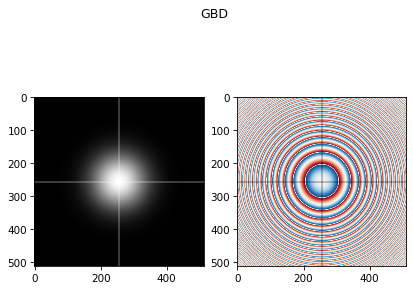

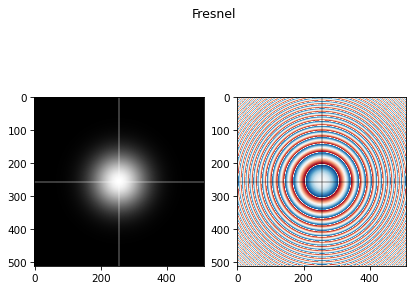

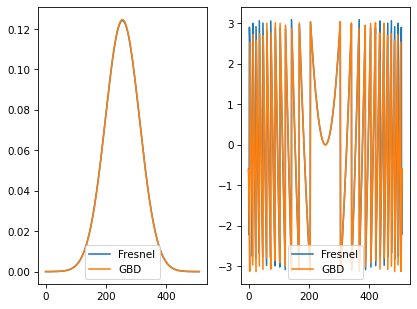

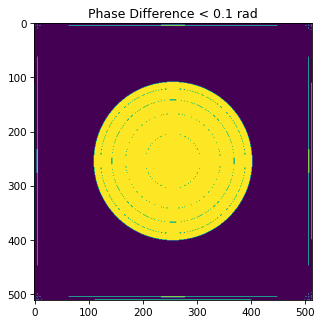

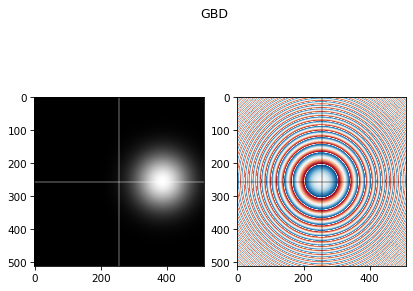

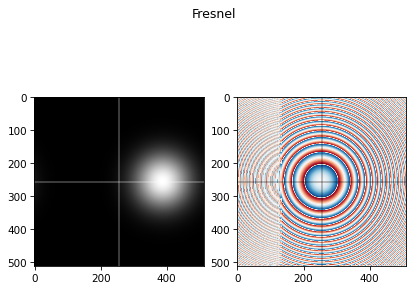

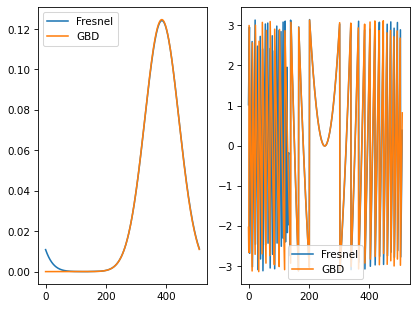

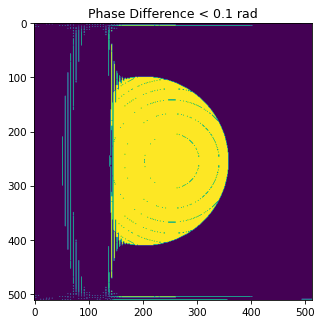

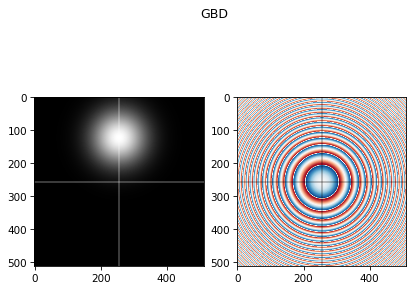

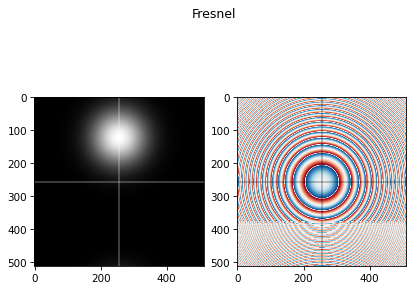

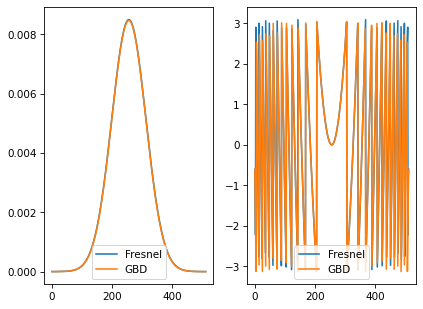

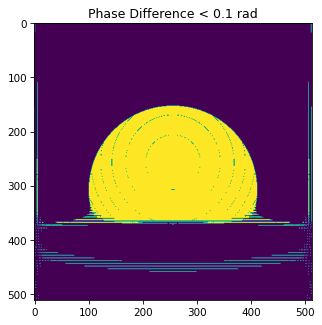

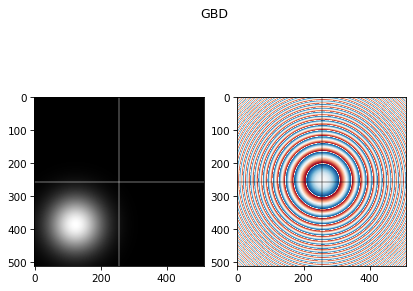

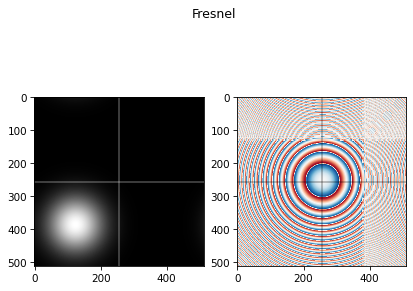

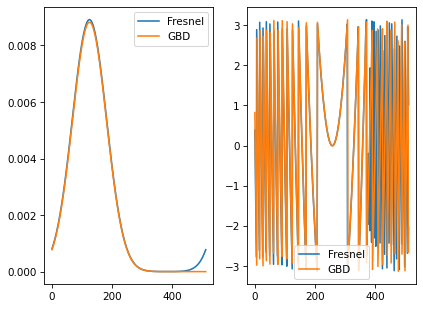

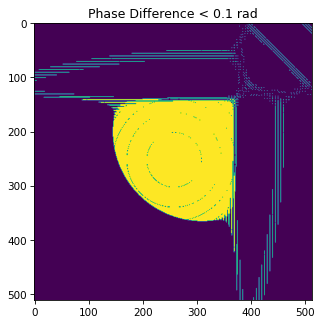

In [3]:
%%ipytest -qq

def test_gaussian_with_free_space(gaussian_beam_freespace_model):
    
    n_rays = 1
    model, wavelength, deg_yx, x0, wo, prop_dist = gaussian_beam_freespace_model

    rays = tuple(model.run_iter(num_rays=n_rays, random=False))
    gbd_output_field = model.detector.get_image(rays[-1])

    size = gbd_output_field.shape[0]

    gbd_output_field = zero_phase(gbd_output_field,
                                    gbd_output_field.shape[0]//2,
                                    gbd_output_field.shape[1]//2)

    # Calculate theta and phi
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    pixel_size = model.components[1].pixel_size

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    shape = model.components[-1].shape
    det_size_y = shape[0] * pixel_size
    det_size_x = shape[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, shape[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, shape[1])

    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
    fresnel_output_field = FresnelPropagator(fresnel_input_field.u,
                                                pixel_size,
                                                wavelength,
                                                prop_dist)

    fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    mask = xp.sqrt((x - center_x)**2 + (y - center_y)**2) <= 25

    # Check if all pixels within the mask satisfy the isclose condition
    is_close = np.isclose(
        np.angle(gbd_output_field),
        np.angle(fresnel_output_field),
        atol=0.1,
    )

    xp.testing.assert_(np.all(is_close[mask]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(gbd_output_field), cmap='gray')
    ax1.axvline(size // 2, color='white', alpha=0.3)
    ax1.axhline(size // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(gbd_output_field), cmap='RdBu')
    ax2.axvline(size // 2, color='k', alpha=0.3)
    ax2.axhline(size // 2, color='k', alpha=0.3)
    fig.suptitle("GBD")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(fresnel_output_field), cmap='gray')
    ax1.axvline(size // 2, color='white', alpha=0.3)
    ax1.axhline(size // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu')
    ax2.axvline(size // 2, color='k', alpha=0.3)
    ax2.axhline(size // 2, color='k', alpha=0.3)
    fig.suptitle("Fresnel")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    s = np.s_[size // 2, :]
    ax1.plot(np.abs(fresnel_output_field[s]), label="Fresnel")
    ax1.plot(np.abs(gbd_output_field[s]), label="GBD")
    ax1.legend()
    ax2.plot(np.angle(fresnel_output_field[s]), label="Fresnel")
    ax2.plot(np.angle(gbd_output_field[s]), label="GBD")
    ax2.legend()

    fig, ax1 = plt.subplots()
    ax1.set_title("Phase Difference < 0.1 rad")
    ax1.imshow(is_close)

....                                                                                         [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model0]
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model1]
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model2]
tests/gaussian_beam_tests/t_c3a6012f369344448f1bf93ca3b11f83.py::test_gaussian_beam_with_lens[gaussian_beam_lens_model3]
  \\grenfshome01\DL277493\TemGym\src\temgymbasic\utils.py:320: RuntimeWarning: invalid value encountered in sqrt
    radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


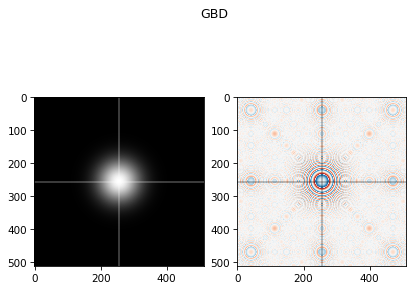

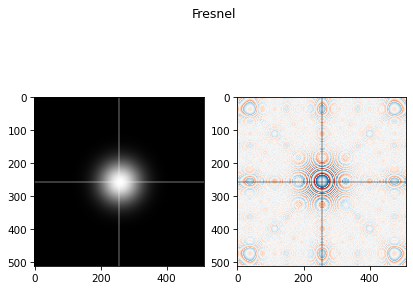

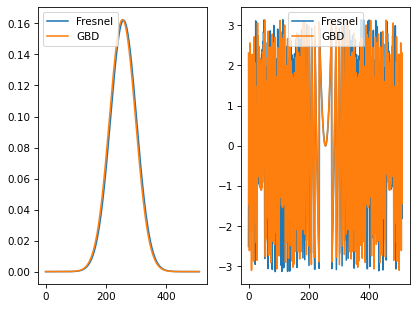

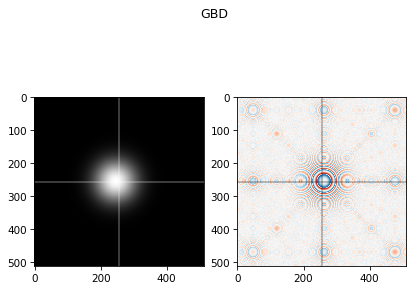

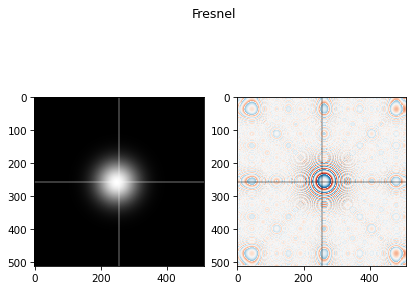

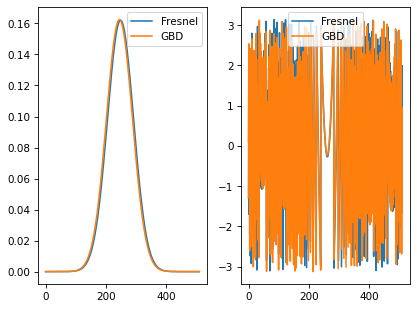

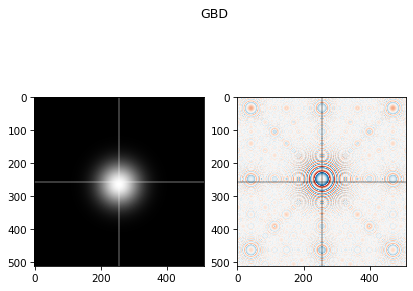

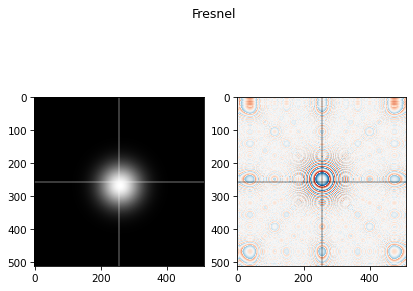

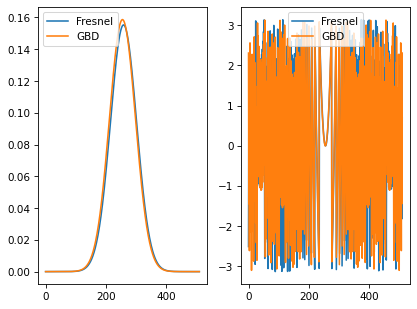

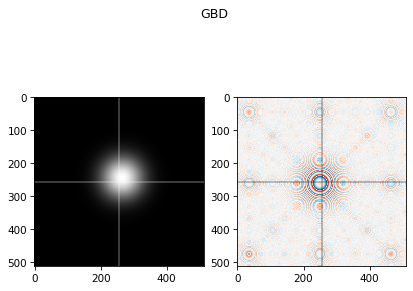

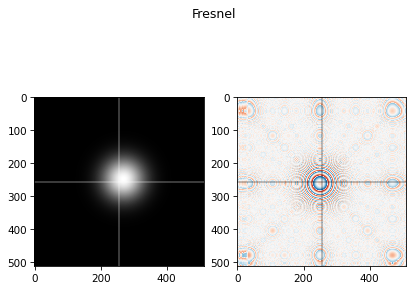

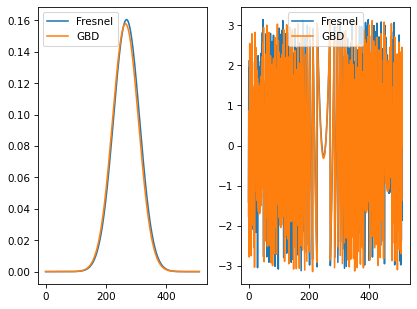

In [4]:
%%ipytest -qq

def test_gaussian_beam_with_lens(gaussian_beam_lens_model):
    
    n_rays = 1
    model, wavelength, deg_yx, x0, wo, prop_dist, lens_dist, focal = gaussian_beam_lens_model

    rays = tuple(model.run_iter(num_rays=n_rays, random=False))
    gbd_output_field = model.detector.get_image(rays[-1])

    size = gbd_output_field.shape[0]

    gbd_output_field = zero_phase(gbd_output_field,
                                    gbd_output_field.shape[0]//2,
                                    gbd_output_field.shape[1]//2)

    # Calculate theta and phi
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    pixel_size = model.components[2].pixel_size

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    shape = model.components[-1].shape
    det_size_y = shape[0] * pixel_size
    det_size_x = shape[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, shape[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, shape[1])

    # Calculate theta and phi
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)

    fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, lens_dist)
    fresnel_output_field = fresnel_output_field * lens_phase_factor(size, pixel_size, wavelength, focal)
    fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, prop_dist)
    fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    mask = xp.sqrt((x - center_x)**2 + (y - center_y)**2) <= 25

    #Not possible with the lens to test properly - too much deviation outside the centre of the lens
    # Check if all pixels within the mask satisfy the isclose condition
    # is_close = np.isclose(
    #     np.angle(gbd_output_field),
    #     np.angle(fresnel_output_field),
    #     atol=0.5,
    # )

    # xp.testing.assert_(np.all(is_close[mask]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(gbd_output_field), cmap='gray')
    ax1.axvline(size // 2, color='white', alpha=0.3)
    ax1.axhline(size // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(gbd_output_field), cmap='RdBu')
    ax2.axvline(size // 2, color='k', alpha=0.3)
    ax2.axhline(size // 2, color='k', alpha=0.3)
    fig.suptitle("GBD")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(fresnel_output_field), cmap='gray')
    ax1.axvline(size // 2, color='white', alpha=0.3)
    ax1.axhline(size // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu')
    ax2.axvline(size // 2, color='k', alpha=0.3)
    ax2.axhline(size // 2, color='k', alpha=0.3)
    fig.suptitle("Fresnel")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    s = np.s_[size // 2, :]
    ax1.plot(np.abs(fresnel_output_field[s]), label="Fresnel")
    ax1.plot(np.abs(gbd_output_field[s]), label="GBD")
    ax1.legend()
    ax2.plot(np.angle(fresnel_output_field[s]), label="Fresnel")
    ax2.plot(np.angle(gbd_output_field[s]), label="GBD")
    ax2.legend()

In [5]:
#Test Defocus

In [6]:
#Test Spherical aberration, distortion and coma

In [7]:
#Test Aperture Diffraction Pattern

In [8]:
#Test Arago Spot